In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from utils.bert import BERTFakeNewsClassifier
from utils.rnn import RNNFakeNewsClassifier, build_vocabulary, preprocess_text

In [3]:
def load_datasets():
    """Load and combine both true and fake news datasets"""
    print("Loading datasets...")
    
    dataset_files = {
        'true': '../dataset/dataset/datasets/True.csv',
        'false': '../dataset/dataset/datasets/Fake.csv'
    }
    
    dataframes = []
    
    for label_name, file_path in dataset_files.items():
        try:
            print(f"Loading {file_path}...")
            df = pd.read_csv(file_path)
            df['binary_label'] = 0 if label_name == 'true' else 1
            df['source_file'] = label_name
            print(f"   Loaded: {len(df)} {label_name} news samples")
            dataframes.append(df)
        except Exception as e:
            raise FileNotFoundError(f"Error loading {file_path}: {str(e)}")
    
    if len(dataframes) == 0:
        raise FileNotFoundError("No dataset files found")
    
    combined_df = pd.concat(dataframes, ignore_index=True)
    
    # Find text column
    text_column = None
    for col in ['text', 'title']:
        if col in combined_df.columns:
            text_column = col
            break
    
    if text_column is None:
        text_columns = combined_df.select_dtypes(include=['object']).columns
        if len(text_columns) > 0:
            text_column = text_columns[0]
    
    if text_column is None:
        raise ValueError("No text column found in dataset")
    
    print(f"\nDataset Summary:")
    print(f"Total samples: {len(combined_df)}")
    print(f"Text column: '{text_column}'")
    
    distribution = combined_df['binary_label'].value_counts()
    for label, count in distribution.items():
        label_name = "Fake News" if label == 1 else "Real News"
        percentage = (count / len(combined_df)) * 100
        print(f"  {label} ({label_name}): {count} ({percentage:.1f}%)")
    
    return combined_df, text_column

def create_balanced_dataset(df, text_column, max_samples_per_class=None):
    """Create a balanced dataset"""
    print("\nBalancing dataset...")
    
    class_counts = df['binary_label'].value_counts()
    min_samples = class_counts.min()
    
    if max_samples_per_class:
        min_samples = min(max_samples_per_class, min_samples)
    
    print(f"Using {min_samples} samples per class...")
    
    balanced_dfs = []
    for label in df['binary_label'].unique():
        class_df = df[df['binary_label'] == label].sample(n=min_samples, random_state=42)
        balanced_dfs.append(class_df)
    
    balanced_df = pd.concat(balanced_dfs, ignore_index=True)
    
    texts = balanced_df[text_column].fillna('').tolist()
    labels = balanced_df['binary_label'].tolist()
    
    print(f"Balanced dataset created: {len(texts)} total samples")
    balanced_counts = balanced_df['binary_label'].value_counts()
    for label, count in balanced_counts.items():
        label_name = "Fake News" if label == 1 else "Real News"
        print(f"  {label} ({label_name}): {count}")
    
    return texts, labels

def split_data(texts, labels, test_size=0.2, val_size=0.1):
    """Split data into train, validation, and test sets"""
    print(f"\nSplitting data...")
    
    X_train, X_temp, y_train, y_temp = train_test_split(
        texts, labels, test_size=test_size+val_size, random_state=42, stratify=labels
    )
    
    val_ratio = val_size / (test_size + val_size)
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=1-val_ratio, random_state=42, stratify=y_temp
    )
    
    print(f"Training set: {len(X_train)} samples")
    print(f"Validation set: {len(X_val)} samples")
    print(f"Test set: {len(X_test)} samples")
    
    return X_train, X_val, X_test, y_train, y_val, y_test

# BERT

In [4]:
def train_bert_model(X_train, X_val, X_test, y_train, y_val, y_test):
    """Train BERT model"""
    print("\n" + "="*50)
    print("Training BERT Model")
    print("="*50)
    
    bert_classifier = BERTFakeNewsClassifier(model_name='distilbert-base-uncased')
    bert_classifier.prepare_data(X_train, X_val, X_test, y_train, y_val, y_test)
    
    bert_classifier.train(epochs=3, batch_size=16, learning_rate=2e-5)
    
    test_loss, test_acc, predictions, true_labels, report, cm = bert_classifier.test_model()
    
    print(f"BERT Test Accuracy: {test_acc:.4f}")
    
    return bert_classifier, test_acc

# RNN + LSTM + GRU

In [5]:
def train_rnn_model(X_train, X_val, X_test, y_train, y_val, y_test):
    """Train RNN model"""
    print("\n" + "="*50)
    print("Training RNN Model")
    print("="*50)
    
    # Build vocabulary from training data
    processed_texts = [preprocess_text(text) for text in X_train]
    vocab_to_idx, vocab = build_vocabulary(processed_texts, min_freq=3, max_vocab_size=15000)
    vocab_size = len(vocab)
    
    print(f"Vocabulary size: {vocab_size}")
    
    rnn_classifier = RNNFakeNewsClassifier(
        vocab_size=vocab_size,
        embed_dim=128,
        hidden_dim=256,
        num_layers=2,
        dropout=0.4,
        rnn_type='LSTM',
        bidirectional=True
    )
    
    rnn_classifier.prepare_data(X_train, X_val, X_test, y_train, y_val, y_test, vocab_to_idx)
    
    rnn_classifier.train(num_epochs=10, learning_rate=0.001, batch_size=32)
    
    test_loss, test_acc, predictions, true_labels, report, cm = rnn_classifier.test_model()
    
    print(f"RNN Test Accuracy: {test_acc:.4f}")
    
    return rnn_classifier, test_acc

# Plot

In [9]:
def plot_model_comparison(bert_classifier, rnn_classifier):
    """Plot comparison of both models' training progress"""
    print("\nGenerating comparison plots...")
    
    # Create figure with subplots
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('BERT vs RNN Comparison', fontsize=16)
    
    # Plot 1: Training Loss Comparison
    axes[0,0].plot(bert_classifier.train_losses, label='BERT', marker='o', linewidth=2)
    axes[0,0].plot(rnn_classifier.train_losses, label='RNN', marker='s', linewidth=2)
    axes[0,0].set_title('Training Loss Comparison')
    axes[0,0].set_xlabel('Epoch')
    axes[0,0].set_ylabel('Loss')
    axes[0,0].legend()
    axes[0,0].grid(True, alpha=0.3)
    
    # Plot 2: Validation Loss Comparison
    axes[0,1].plot(bert_classifier.val_losses, label='BERT', marker='o', linewidth=2)
    axes[0,1].plot(rnn_classifier.val_losses, label='RNN', marker='s', linewidth=2)
    axes[0,1].set_title('Validation Loss Comparison')
    axes[0,1].set_xlabel('Epoch')
    axes[0,1].set_ylabel('Loss')
    axes[0,1].legend()
    axes[0,1].grid(True, alpha=0.3)
    
    # Plot 3: Validation Accuracy Comparison
    axes[1,0].plot(bert_classifier.val_accuracies, label='BERT', marker='o', linewidth=2)
    axes[1,0].plot(rnn_classifier.val_accuracies, label='RNN', marker='s', linewidth=2)
    axes[1,0].set_title('Validation Accuracy Comparison')
    axes[1,0].set_xlabel('Epoch')
    axes[1,0].set_ylabel('Accuracy')
    axes[1,0].legend()
    axes[1,0].grid(True, alpha=0.3)
    
    # Plot 4: Training Accuracy Comparison (for RNN only, BERT doesn't track this)
    if hasattr(rnn_classifier, 'train_accuracies') and rnn_classifier.train_accuracies:
        axes[1,1].plot(rnn_classifier.train_accuracies, label='RNN Training', marker='s', linewidth=2)
        axes[1,1].plot(rnn_classifier.val_accuracies, label='RNN Validation', marker='o', linewidth=2)
        axes[1,1].set_title('RNN Training vs Validation Accuracy')
        axes[1,1].set_xlabel('Epoch')
        axes[1,1].set_ylabel('Accuracy')
        axes[1,1].legend()
        axes[1,1].grid(True, alpha=0.3)
    else:
        axes[1,1].axis('off')
    
    plt.tight_layout()
    plt.show()
    print("Model comparison plot displayed")

def plot_final_accuracy_comparison(bert_acc, rnn_acc):
    """Plot final test accuracy comparison"""
    models = ['BERT', 'RNN']
    accuracies = [bert_acc, rnn_acc]
    
    plt.figure(figsize=(8, 6))
    bars = plt.bar(models, accuracies, color=['#1f77b4', '#ff7f0e'], alpha=0.8)
    plt.title('Test Accuracy Comparison', fontsize=14, fontweight='bold')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1)
    
    # Add accuracy values on top of bars
    for bar, acc in zip(bars, accuracies):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{acc:.3f}', ha='center', va='bottom', fontweight='bold')
    
    plt.grid(axis='y', alpha=0.3)
    plt.show()
    print("Final accuracy comparison displayed")

# Testing

In [10]:
def test_predictions(bert_classifier, rnn_classifier, X_test, y_test):
    """Test both models on sample texts and show predictions"""
    print("\nTesting sample predictions...")
    
    sample_texts = X_test[:5]
    sample_labels = y_test[:5]
    
    bert_predictions, bert_probs = bert_classifier.predict(sample_texts)
    rnn_predictions, rnn_probs = rnn_classifier.predict(sample_texts)
    
    print(f"\n{'='*60}")
    print("Sample Predictions Comparison")
    print(f"{'='*60}")
    
    for i, (text, true_label) in enumerate(zip(sample_texts, sample_labels)):
        bert_pred = bert_predictions[i]
        rnn_pred = rnn_predictions[i]
        
        bert_conf = max(bert_probs[i]) * 100
        rnn_conf = max(rnn_probs[i]) * 100
        
        true_name = "FAKE" if true_label == 1 else "REAL"
        bert_name = "FAKE" if bert_pred == 1 else "REAL"
        rnn_name = "FAKE" if rnn_pred == 1 else "REAL"
        
        bert_correct = "✓" if bert_pred == true_label else "✗"
        rnn_correct = "✓" if rnn_pred == true_label else "✗"
        
        print(f"\nSample {i+1}:")
        print(f"Text: {text[:100]}...")
        print(f"True Label: {true_name}")
        print(f"BERT: {bert_name} ({bert_conf:.1f}%) {bert_correct}")
        print(f"RNN:  {rnn_name} ({rnn_conf:.1f}%) {rnn_correct}")

In [11]:
# Load datasets
df, text_column = load_datasets()   
    
# Create balanced dataset
texts, labels = create_balanced_dataset(df, text_column, max_samples_per_class=5000)
    
# Split data
X_train, X_val, X_test, y_train, y_val, y_test = split_data(texts, labels)

Loading datasets...
Loading ../dataset/dataset/datasets/True.csv...
   Loaded: 21417 true news samples
Loading ../dataset/dataset/datasets/Fake.csv...
   Loaded: 23481 false news samples

Dataset Summary:
Total samples: 44898
Text column: 'text'
  1 (Fake News): 23481 (52.3%)
  0 (Real News): 21417 (47.7%)

Balancing dataset...
Using 5000 samples per class...
Balanced dataset created: 10000 total samples
  0 (Real News): 5000
  1 (Fake News): 5000

Splitting data...
Training set: 6999 samples
Validation set: 1000 samples
Test set: 2001 samples


In [12]:
# Train both models
bert_classifier, bert_accuracy = train_bert_model(X_train, X_val, X_test, y_train, y_val, y_test)
rnn_classifier, rnn_accuracy = train_rnn_model(X_train, X_val, X_test, y_train, y_val, y_test)


Training BERT Model


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
BERT Epoch 3/3: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 438/438 [04:25<00:00,  1.65it/s, loss=0.0002]


BERT Test Accuracy: 1.0000

Training RNN Model


Tokenizing texts: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6999/6999 [00:08<00:00, 834.23it/s]


Vocabulary size: 15000


RNN Epoch 10/10: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 219/219 [00:17<00:00, 12.86it/s, loss=0.0042]
/root/deepLearning/src/utils/rnn.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full con

RNN Test Accuracy: 0.9980



Generating comparison plots...


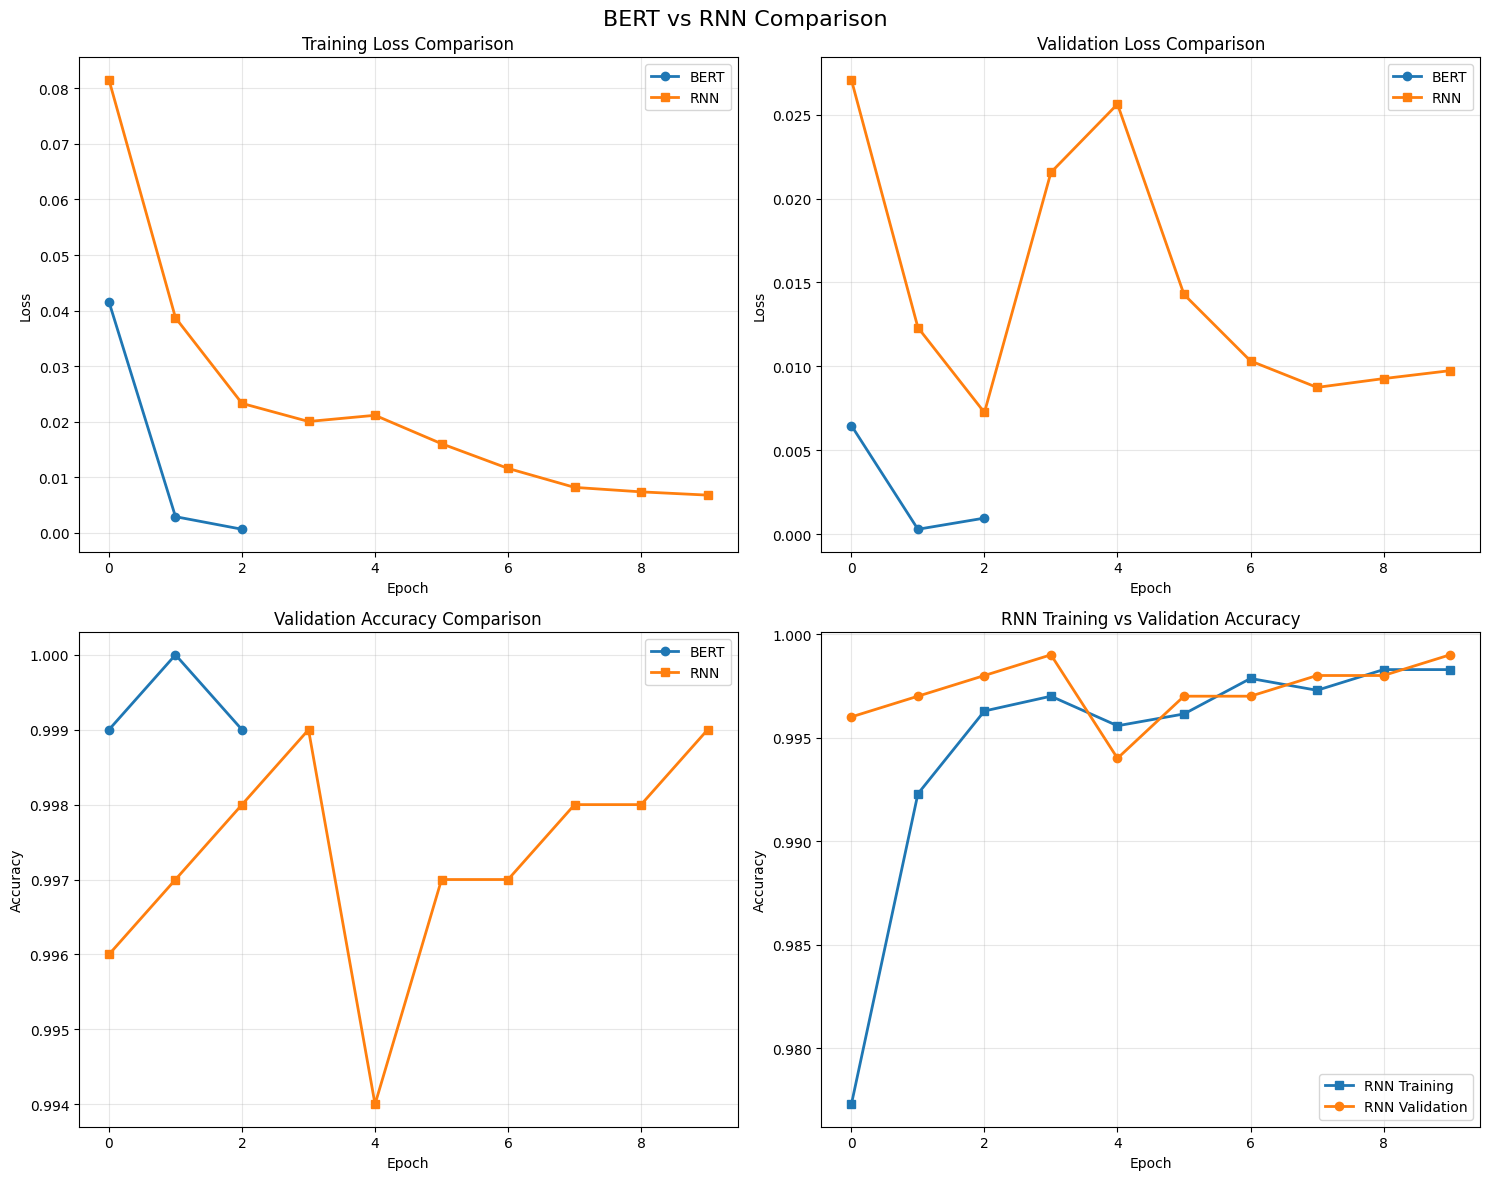

Model comparison plot displayed


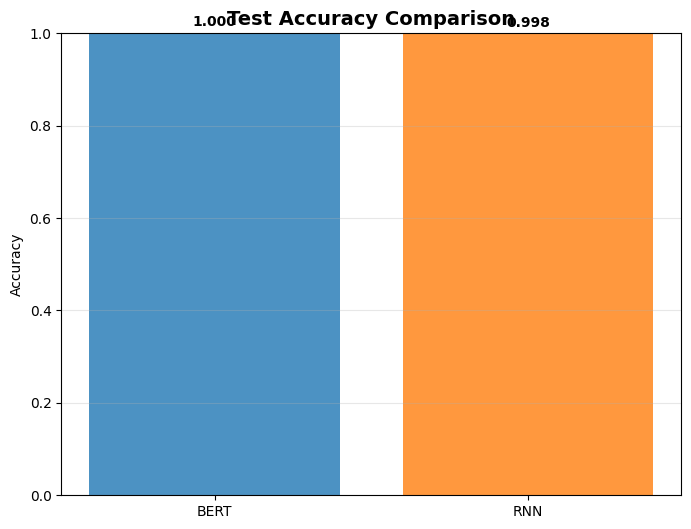

Final accuracy comparison displayed


In [13]:
# Generate comparison plots
plot_model_comparison(bert_classifier, rnn_classifier)
plot_final_accuracy_comparison(bert_accuracy, rnn_accuracy)

In [14]:
# Test sample predictions
test_predictions(bert_classifier, rnn_classifier, X_test, y_test)
    
print("Final Results Summary \n")
print(f"BERT Test Accuracy: {bert_accuracy:.4f} ({bert_accuracy*100:.2f}%)")
print(f"RNN Test Accuracy:  {rnn_accuracy:.4f} ({rnn_accuracy*100:.2f}%)")


Testing sample predictions...

Sample Predictions Comparison

Sample 1:
Text: WASHINGTON (Reuters) - Protesters at Howard University chanted and booed on Friday through James Com...
True Label: REAL
BERT: REAL (100.0%) ✓
RNN:  REAL (99.9%) ✓

Sample 2:
Text: BENGHAZI, Libya (Reuters) - Armed men blew up a pipeline pumping crude oil to Es Sider port on Tuesd...
True Label: REAL
BERT: REAL (100.0%) ✓
RNN:  REAL (99.4%) ✓

Sample 3:
Text: If it weren t for the whiney phrase,  political correctness,  which is really just another phrase fo...
True Label: FAKE
BERT: FAKE (100.0%) ✓
RNN:  FAKE (96.4%) ✓

Sample 4:
Text: It has been 15 years since the World Trade Center Twin Towers fell. But Republicans and Donald Trump...
True Label: FAKE
BERT: FAKE (100.0%) ✓
RNN:  FAKE (95.3%) ✓

Sample 5:
Text: Russian interference in our election should immediately disqualify Donald Trump from the presidency....
True Label: FAKE
BERT: FAKE (100.0%) ✓
RNN:  FAKE (98.2%) ✓
Final Results Summary 

BERT Test